<a href="https://colab.research.google.com/github/dmehdipour/pytorch/blob/main/MultiClass_ClassificationModel_Spiral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torchmetrics

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File is already exist")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py","wb") as f:
    f.write(request.content)

File is already exist


In [ ]:
import torch
from torch import nn

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

from torchmetrics import Accuracy

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

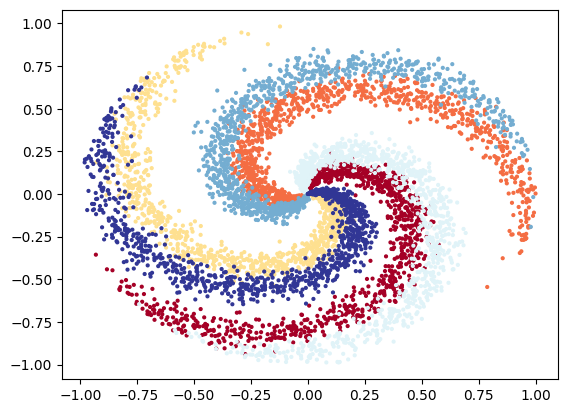

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N_SAMPLE = 1000 # number of points per class
N_FEATURE = 2 # dimensionality
N_CLASS = 6 # number of classes
X = np.zeros((N_SAMPLE*N_CLASS,N_FEATURE)) # data matrix (each row = single example)
y = np.zeros(N_SAMPLE*N_CLASS, dtype='uint8') # class labels
for j in range(N_CLASS):
  ix = range(N_SAMPLE*j,N_SAMPLE*(j+1))
  r = np.linspace(0.0,1,N_SAMPLE) # radius
  t = np.linspace(j*4,(j+1)*4,N_SAMPLE) + np.random.randn(N_SAMPLE)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=4, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

class ClassificationModelV2(nn.Module):
  def __init__(self, input_features, output_features, hidden_state=8):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_state),
        nn.ReLU(),
        nn.Linear(in_features=hidden_state, out_features=hidden_state),
        nn.ReLU(),
        nn.Linear(in_features=hidden_state, out_features=output_features)
    )

  def forward(self, x):
    return self.layers(x)

model_3=ClassificationModelV2(input_features=2, output_features=N_CLASS, hidden_state=10).to(device)
model_3

ClassificationModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=6, bias=True)
  )
)

In [ ]:
epochs=500

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_3.parameters(),
                           lr=0.02)
accuracy_fn = Accuracy(task="multiclass", num_classes=N_CLASS).to(device)

for epoch in range(1,epochs+1):
  model_3.train()
  y_logits=model_3(X_train)
  y_pred=torch.softmax(y_logits, dim=1).argmax(dim=1)

  train_loss=loss_fn(y_logits, y_train)
  train_acc=accuracy_fn(y_pred, y_train)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_test)
    test_pred=torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss=loss_fn(test_logits, y_test)
    test_acc=accuracy_fn(test_pred, y_test)

  if epoch%100==0:
    print(f"Epochs: {epoch} | Train_loss: {train_loss:.4f}, Train_acc: {train_acc:.2f}% | Test_loss: {test_loss:.4f}, Test_acc: {test_acc:.2f}%")

Epochs: 100 | Train_loss: 1.0493, Train_acc: 0.51% | Test_loss: 0.9985, Test_acc: 0.54%
Epochs: 200 | Train_loss: 0.4045, Train_acc: 0.84% | Test_loss: 0.4266, Test_acc: 0.85%
Epochs: 300 | Train_loss: 0.3104, Train_acc: 0.88% | Test_loss: 0.3615, Test_acc: 0.86%
Epochs: 400 | Train_loss: 0.2744, Train_acc: 0.90% | Test_loss: 0.3285, Test_acc: 0.87%
Epochs: 500 | Train_loss: 0.2587, Train_acc: 0.90% | Test_loss: 0.3202, Test_acc: 0.88%


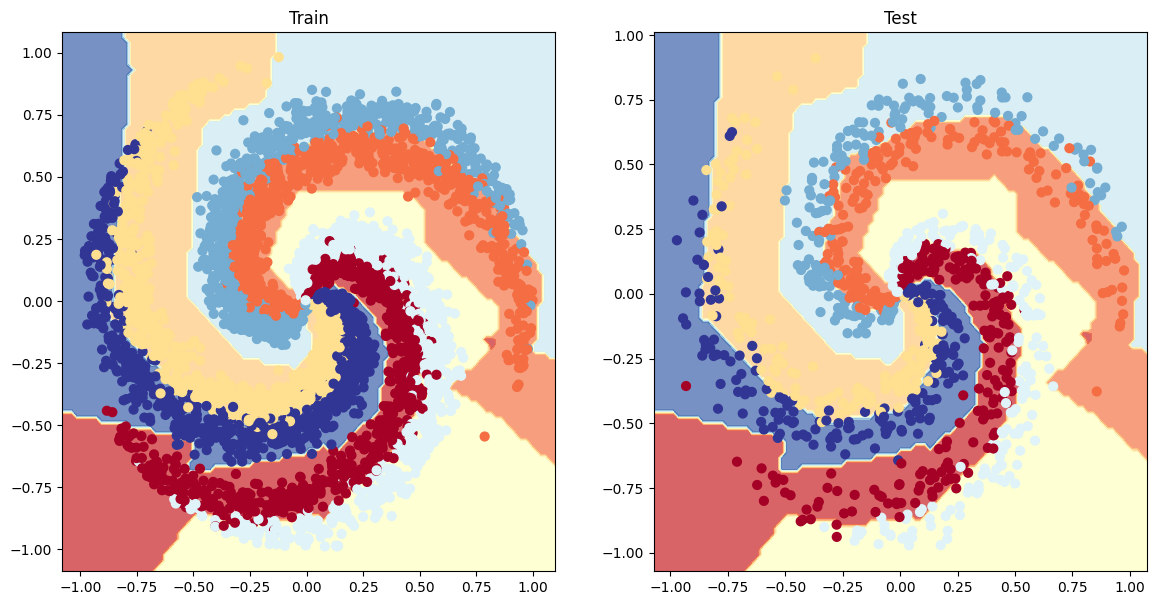

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,
                       X_train,
                       y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,
                       X_test,
                       y_test)